# U-Net on Graphene Images
This is a modification to a U-Net on the Oxford-IIIT Pet Dataset. Original code is located at https://colab.research.google.com/github/zaidalyafeai/Notebooks/blob/master/unet.ipynb

Mount Google Drive and define path to dataset. There are two paths: one to the dataset (dataset_dir) and another to the folder which you put `utils.py' in (project_dir).

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install SPIEPy
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 17.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 14.3 MB/s 


In [3]:
import os
import sys
project_dir = os.path.abspath("/content/gdrive/MyDrive/defect_DL/")
dataset_dir = os.path.abspath("//content/gdrive/MyDrive/defect_DL/")

# model paths to save or load the models
model_path = "/content/gdrive/MyDrive/defect_DL/Unet_h5_files/model.h5"

sys.path.append(project_dir)  # To find local version of the library: utils
import utils2021

Import the libraries for use

In [4]:
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf
import cv2
from imgaug import augmenters as iaa
from scipy import ndimage, signal
from scipy import fftpack
from skimage import exposure
import glob
from PIL import Image, ImageDraw
import spiepy, spiepy.demo
from skimage import io
import tensorflow_addons as tfa

# Define hyper-parameters

In [5]:
epochs = 200 # no. of training epochs
batch_size = 8 
default_learning_rate = 0.0006

# define U-Net input image size
default_input_size = (256,256,3)

# define weight of positive errors
pos_weight = 8
 
# start training your model. Set to 0 if you want to train from scratch
initial_epoch = 190
threshold = 0.5

Define augmenter: 

In [6]:
# define augmenter
# first crop images at a random position
# then randomly apply 0 to 4 of the methods: horizontally flip, vertically flip, rotate and shift
seq_train = iaa.Sequential([
            iaa.SomeOf((0, 4),[
                iaa.Fliplr(), # horizontally flip
                iaa.Flipud(), # vertically flip
                iaa.Affine(rotate=(0,359)), # rotate
                iaa.Affine(translate_percent={"x": (-0.1, 0.1),"y": (-0.1, 0.1)}), # shift
                # More as you want ...
    ])
])


# Generator function
Functions contains "yield" keyword are called generator functions. Unlike "return", "yield" doesn't destroy the state of function. Intuitively, generator functions are similar to a for loop that can only be iterated over once. To learn more, read this: https://pythontips.com/2013/09/29/the-python-yield-keyword-explained/

In [7]:
def draw_cicle(shape,diamiter):
    '''
    Input:
    shape    : tuple (height, width)
    diameter : scalar
    
    Output:
    np.array of shape  that says True within a circle with diamiter =  around center 
    '''
    assert len(shape) == 2
    TF = np.zeros(shape,dtype=np.bool)
    
    center = np.array(TF.shape)/2.0
    for iy in range(shape[0]):
        for ix in range(shape[1]):
            TF[iy,ix] = (iy- center[0])**2 + (ix - center[1])**2 < (diamiter **2)
    return(TF)

def filter_circle(TFcircleIN,fft_img_channel):
    temp = np.zeros(fft_img_channel.shape[:2],dtype=complex)
    temp[TFcircleIN] = fft_img_channel[TFcircleIN]
    return(temp)

def inv_FFT_all_channel(fft_img):
    #img_reco = []
    # for ichannel in range(fft_img.shape[2]):
    #img_reco.append(np.fft.ifft2(np.fft.ifftshift(fft_img[:,:])))
    img_reco = np.fft.ifftshift(fft_img[:,:])
    img_reco = np.fft.ifft2(img_reco)
    img_reco = np.array(img_reco)
    img_reco = np.transpose(img_reco)
    return(img_reco)

In [8]:
from skimage.color import rgb2gray

def image_generator(dataset,seq=None, batch_size = 32, image_size = (1024,1024)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(dataset.image_ids, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    if seq: # apply augmentation
      # make stochastic augmenter deterministic (similar to drawing random samples from a distribution)
        seq_det = seq.to_deterministic()

    for f in batch:

        #preprocess the raw images 
        raw = cv2.resize(dataset.load_image(f),
        dsize=default_input_size[:2],
        interpolation=cv2.INTER_CUBIC)
        raw = rgb2gray(raw) 
 
        img=raw
        shape = img.shape[:]

        TFcircleIN   = draw_cicle(shape=img.shape[:],diamiter = 40)
        TFcircleOUT  = ~TFcircleIN

        fft_img = np.zeros_like(img,dtype=complex)

        fft_img[:,:] = np.fft.fftshift(np.fft.fft2(img[:,:]))

        fft_img_channel  = fft_img[:,:]
        temp1 = filter_circle(TFcircleIN,fft_img_channel)

        fft_img_filtered_IN = np.transpose(temp1)
        img_reco_filtered_IN  = inv_FFT_all_channel(fft_img_filtered_IN)

        raw = img_reco_filtered_IN
        
        raw = np.stack([raw,raw,raw], axis = -1)

        raw = np.array(tf.image.adjust_contrast(np.abs(raw),1.3)) 
        raw=np.clip(raw,0,1)
        #get the mask
        gt_mask = dataset.load_mask(f)
        mask_impurity = np.clip(np.sum(gt_mask[0][:,:,[i for i in range(len(gt_mask[1])) if gt_mask[1][i] ==1]], axis = -1, keepdims = True), a_min = 0, a_max = 1)
        mask_void = np.clip(np.sum(gt_mask[0][:,:,[i for i in range(len(gt_mask[1])) if gt_mask[1][i] ==2]], axis = -1, keepdims = True), a_min = 0, a_max = 1)
        
        mask_impurity = cv2.resize(mask_impurity.astype(np.float32), dsize=image_size, interpolation=cv2.INTER_CUBIC)
        mask_void = cv2.resize(mask_void.astype(np.float32), dsize=image_size, interpolation=cv2.INTER_CUBIC)
        

        mask_impurity[mask_impurity != 0 ] = 1
        mask_void[mask_void != 0 ] = 1
        background = 1- (mask_impurity + mask_void)
        
        mask = np.stack([mask_impurity, mask_void, background], axis = 2)

        # pre-process the mask 
        #mask[mask != 0 ] = 1
        batch_x.append(raw)
        batch_y.append(mask)

    # pre-process a batch of images and masks 
    batch_x = np.array(batch_x) # normalize raw images
    batch_y = np.array(batch_y)
    #batch_y = np.expand_dims(np.array(batch_y),3)# add color channel to the black-and-white masks

    if seq:
        # augment images and masks
        batch_x = np.array(seq_det.augment_images(batch_x))
        batch_y = np.array(seq_det.augment_images(batch_y))

    yield (batch_x, batch_y)

In [9]:
# build a CocoDataset object for training images
dataset_train = utils2021.CocoDataset()
dataset_train.load_coco(dataset_dir, "train")
dataset_train.prepare()

# build a CocoDataset object for validation images
dataset_val = utils2021.CocoDataset()
dataset_val.load_coco(dataset_dir, "val")
dataset_val.prepare()

# build generators for training and testing
train_generator = image_generator(dataset_train,seq=seq_train, batch_size = batch_size,image_size=default_input_size[:2])

test_generator  = image_generator(dataset_val,seq=None, batch_size = batch_size, image_size=default_input_size[:2])

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


Test the generators by plotting the images

In [10]:
def returnrgb(arr):
    a=np.zeros(np.shape(arr[:,:,1]))
    arr[:,:,2]=a
    return arr


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


(8, 256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Text(0.5, 1.0, 'BG Impurity Ground Truth')

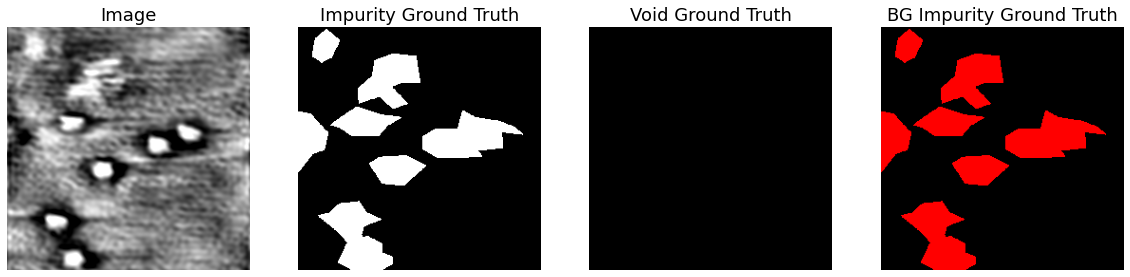

In [11]:
x, y= next(test_generator) # x is the raw images, y is the ground truth masks

print(np.shape(x))
print(np.shape(y[0]))

img = x[0]
#print(img)
print(np.shape(img))
#batch_y = np.expand_dims(np.array(img),3)
#img = rgb2gray(img)
msk = y[0].squeeze()
#msk = np.stack((msk,)*3, axis = -1)
print(np.shape(msk[:,:,]))
fig, ax = plt.subplots(1,4,figsize = (20,80))
[axi.set_axis_off() for axi in ax.ravel()]

ax[0].imshow(img)
ax[0].set_title('Image',fontsize=18)
ax[1].imshow(msk[:,:,0], cmap = 'gray')
ax[1].set_title('Impurity Ground Truth',fontsize=18)
ax[2].imshow(msk[:,:,1], cmap = 'gray')
ax[2].set_title('Void Ground Truth',fontsize=18)
ax[3].imshow(returnrgb(msk),cmap="gray")
ax[3].set_title('BG Impurity Ground Truth',fontsize=18)


# Weighted binary crossentropy loss 
Assume we have $N$ samples in total, $y_{true}$ is a ground truth segmentation mask, $y_{pred}$ is the CNN-predicted segmentation mask, the binary crossentropy is defined as:
$$L_{binary\_ce} = -\frac{1}{N}\sum_{1}^{N}y_{true} * log(y_{pred})+(1-y_{true})*log(1-y_{pred})$$
And weighted binary crossentropy is defined as:
$$L_{w\_binary\_ce} = -\frac{1}{N}\sum_{1}^{N} w * y_{true} * log(y_{pred})+(1-y_{true})*log(1-y_{pred})$$
Here, $w$ represents the weight for positive errors. Weighted loss here is used to handle class imbalance in the dataset.

In [12]:
def create_weighted_binary_crossentropy(pos_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        weight_vector = y_true * pos_weight + (1. - y_true)
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

# Define the UNet model function

In [13]:
def unet(sz = default_input_size):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  
  for i in range(6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(3, (1, 1), activation='softmax') (x)
  
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])

  opt = keras.optimizers.Adam(learning_rate=default_learning_rate)
  model.compile(optimizer = opt, loss = create_weighted_binary_crossentropy(pos_weight), metrics = ['accuracy'])
  return model


# Define custom callbacks

In [14]:
def build_callbacks():
  checkpointer = ModelCheckpoint(filepath=model_path, verbose=0, save_best_only=True, save_weights_only=False)
  callbacks = [checkpointer, PlotLearning()]
  return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(epoch)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        #self.acc.append(logs.get('mean_iou'))
        #self.val_acc.append(logs.get('val_mean_iou'))
       
        #print('epoch =',epoch,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'))
        
        #choose a test image and preprocess
        raw = cv2.resize(dataset_val.load_image(0),
        dsize=default_input_size[:2],
        interpolation=cv2.INTER_CUBIC)
        raw = rgb2gray(raw) 
 
        img=raw
        plt.show()
        shape = img.shape[:]

        TFcircleIN   = draw_cicle(shape=img.shape[:],diamiter = 40)
        TFcircleOUT  = ~TFcircleIN

        fft_img = np.zeros_like(img,dtype=complex)

        fft_img[:,:] = np.fft.fftshift(np.fft.fft2(img[:,:]))

        fft_img_channel  = fft_img[:,:]
        temp1 = filter_circle(TFcircleIN,fft_img_channel)

        fft_img_filtered_IN = np.transpose(temp1)
        img_reco_filtered_IN  = inv_FFT_all_channel(fft_img_filtered_IN)

        raw = img_reco_filtered_IN
        
        raw = np.stack([raw,raw,raw], axis = -1)

        raw = np.array(tf.image.adjust_contrast(np.abs(raw), 1.3))
        raw=np.clip(raw,0,1)
        # get ground truth mask
        val_mask = dataset_val.load_mask(0)
        mask_impurity = np.clip(np.sum(val_mask[0][:,:,[i for i in range(len(val_mask[1])) if val_mask[1][i] ==1]], axis = -1, keepdims = True), a_min = 0, a_max = 1)
        mask_void = np.clip(np.sum(val_mask[0][:,:,[i for i in range(len(val_mask[1])) if val_mask[1][i] ==2]], axis = -1, keepdims = True), a_min = 0, a_max = 1)
        
        mask_impurity = cv2.resize(mask_impurity.astype(np.float32), dsize=default_input_size[:2], interpolation=cv2.INTER_CUBIC)
        mask_void = cv2.resize(mask_void.astype(np.float32), dsize=default_input_size[:2], interpolation=cv2.INTER_CUBIC)

        # pre-process the mask 
        
        mask_impurity[mask_impurity != 0 ] = 1
        mask_void[mask_void != 0 ] = 1



        # batch_x.append(raw)
        # batch_y.append(mask)
        # mask = np.tile(mask[:,:,np.newaxis], (1,1,3))

        #predict the mask 
        pred = model_attached.predict(np.expand_dims(raw, 0))
        
        # predicted mask post-processing 
        pred  = pred.squeeze()

        pred_mask = np.array(pred)
        fig, ax = plt.subplots(2,3,figsize=(20,10))
        [axi.set_axis_off() for axi in ax.ravel()]
        ax[0,0].imshow(raw)
        ax[0,0].set_title('Image',fontsize=14)

        ax[0,1].imshow(mask_impurity,cmap='gray')
        ax[0,1].set_title('Impurity Ground Truth',fontsize=14)
        ax[0,2].imshow(mask_void,cmap='gray')
        ax[0,2].set_title('Void Ground Truth',fontsize=14)

        ax[1,0].imshow(pred[:,:,0],cmap='gray')
        ax[1,0].set_title('Impurity Prediction',fontsize=14)
        ax[1,1].imshow(pred[:,:,1],cmap='gray')
        ax[1,1].set_title('Void Prediction',fontsize=14)
        ax[1,2].imshow(returnrgb(pred))
        ax[1,2].set_title('2-class prediction',fontsize=14)

        plt.show()

# Build the model and train

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 256, 256, 8)  224         ['input_2[0][0]']                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 256, 256, 8)  584         ['conv2d_27[0][0]']              
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 128, 128, 8)  0          ['conv2d_28[0][0]']        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


Epoch 191/200
8/8 [==============================] - ETA: 0s - loss: 0.2563 - accuracy: 0.8916

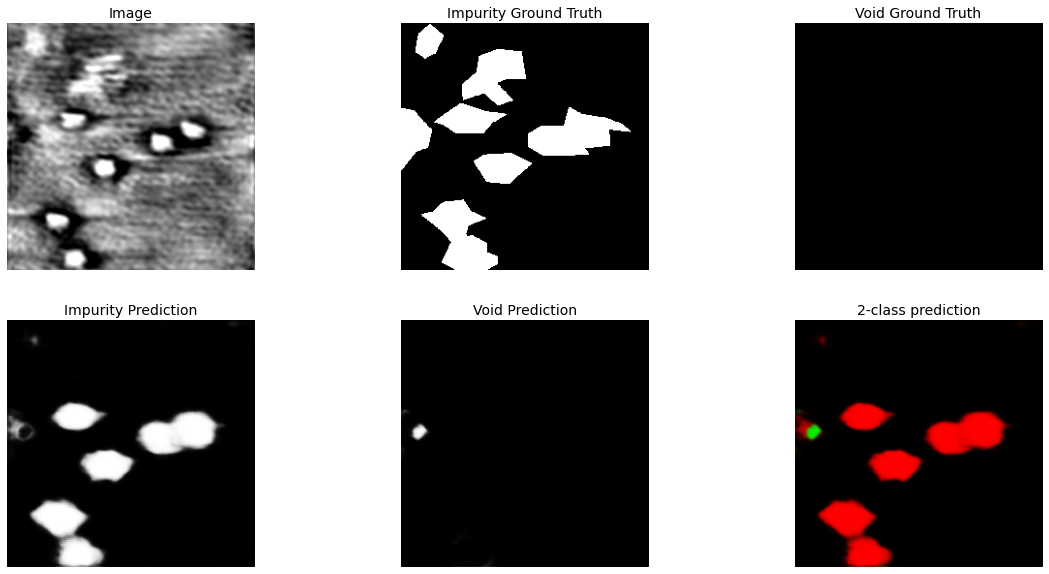

8/8 [==============================] - 38s 5s/step - loss: 0.2563 - accuracy: 0.8916 - val_loss: 0.3978 - val_accuracy: 0.9260
Epoch 192/200
8/8 [==============================] - ETA: 0s - loss: 0.2519 - accuracy: 0.9375

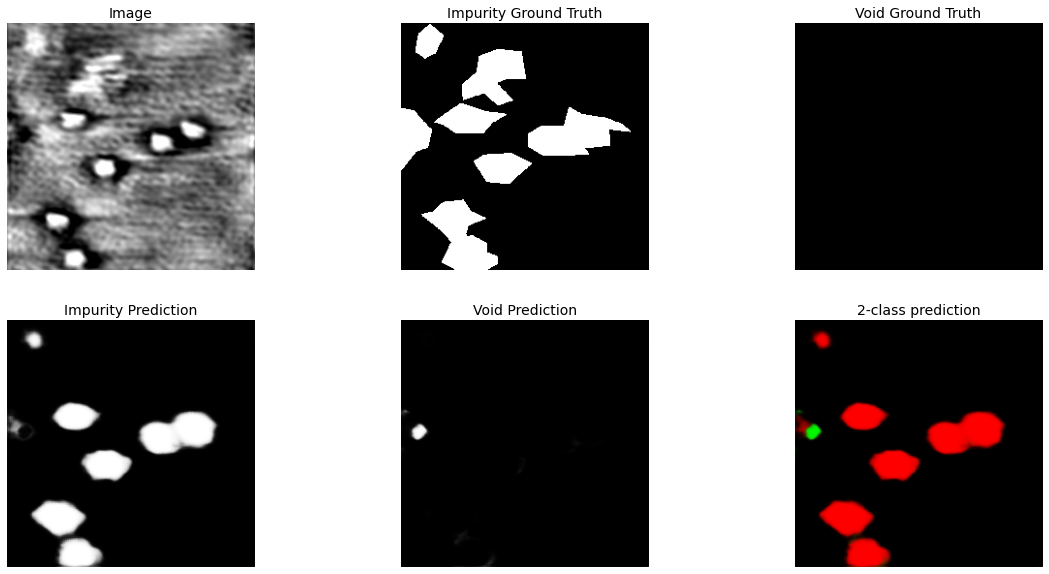

8/8 [==============================] - 26s 4s/step - loss: 0.2519 - accuracy: 0.9375 - val_loss: 0.4861 - val_accuracy: 0.9125
Epoch 193/200
8/8 [==============================] - ETA: 0s - loss: 0.2266 - accuracy: 0.9240

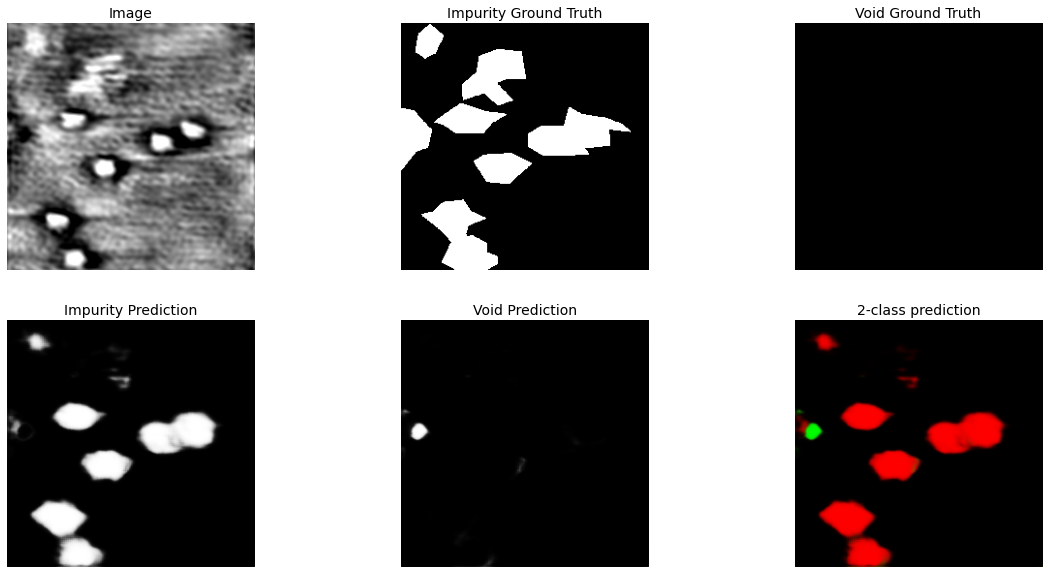

8/8 [==============================] - 25s 3s/step - loss: 0.2266 - accuracy: 0.9240 - val_loss: 0.4067 - val_accuracy: 0.9207
Epoch 194/200
8/8 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.8820

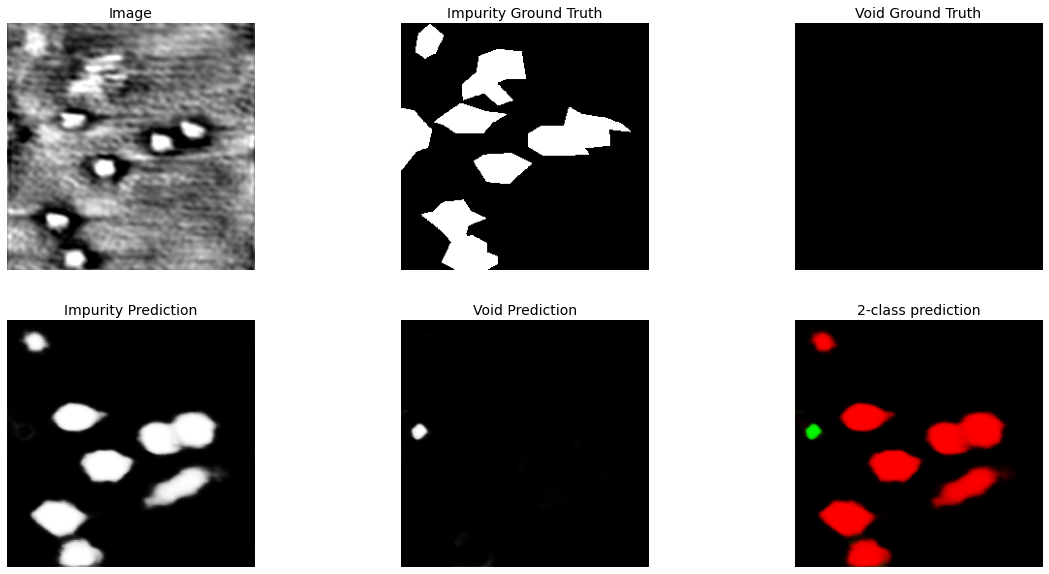

8/8 [==============================] - 22s 3s/step - loss: 0.2473 - accuracy: 0.8820 - val_loss: 0.5150 - val_accuracy: 0.9151
Epoch 195/200
8/8 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9095

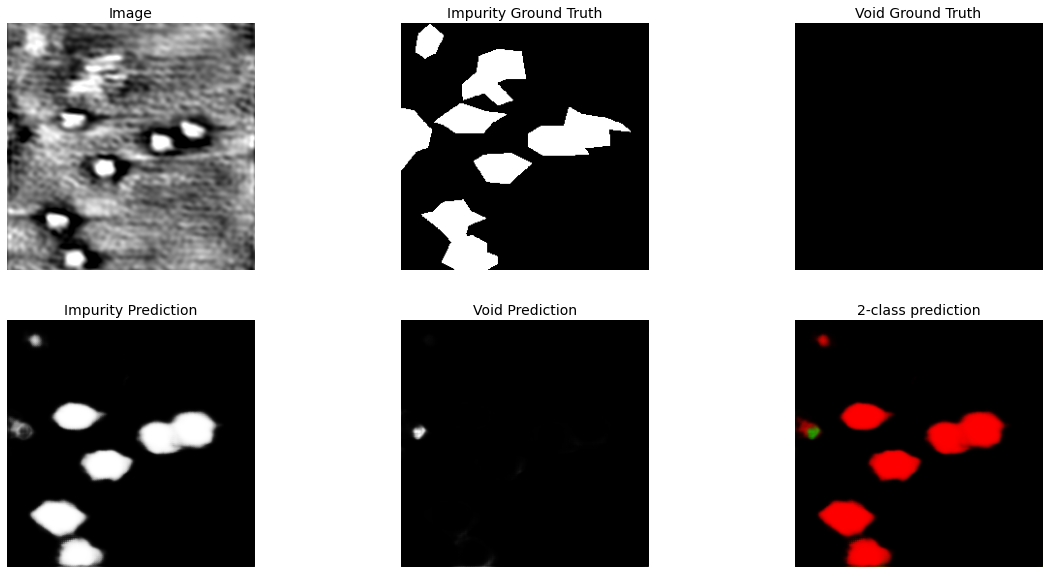

8/8 [==============================] - 21s 3s/step - loss: 0.2245 - accuracy: 0.9095 - val_loss: 0.4545 - val_accuracy: 0.9198
Epoch 196/200
8/8 [==============================] - ETA: 0s - loss: 0.2535 - accuracy: 0.8794

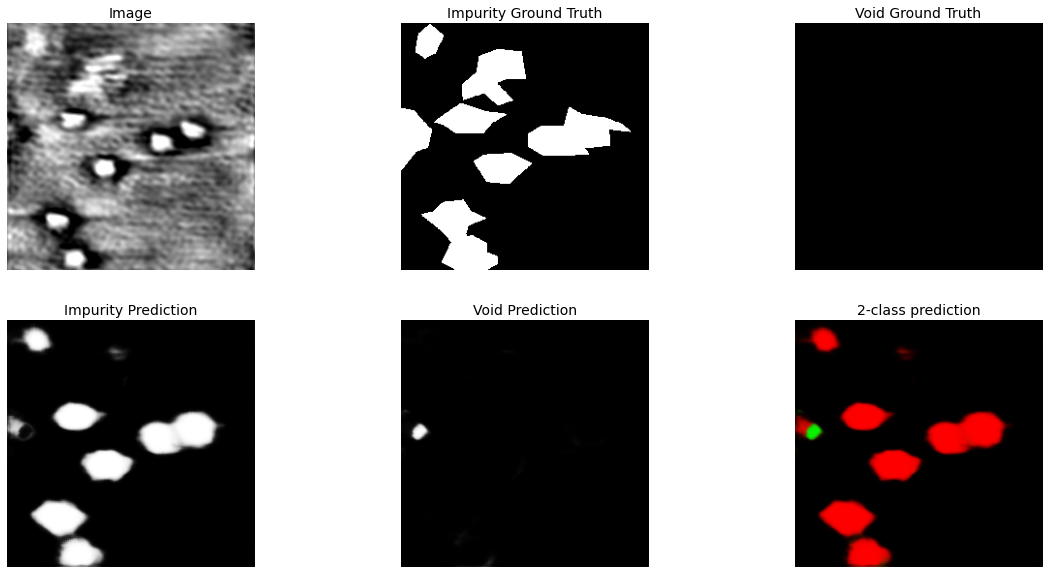

8/8 [==============================] - 23s 3s/step - loss: 0.2535 - accuracy: 0.8794 - val_loss: 0.3935 - val_accuracy: 0.9260
Epoch 197/200
8/8 [==============================] - ETA: 0s - loss: 0.2370 - accuracy: 0.8917

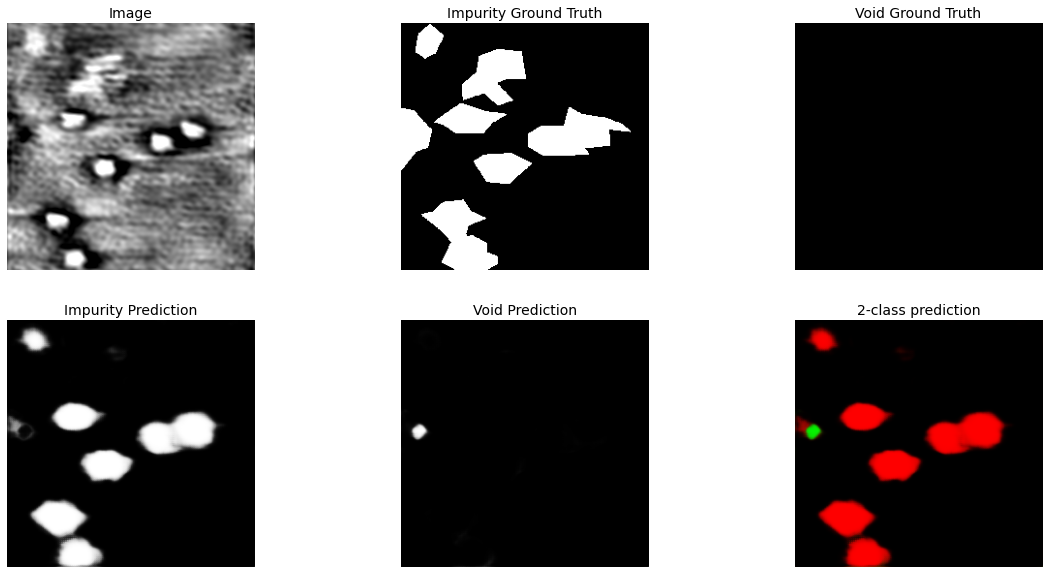

8/8 [==============================] - 23s 3s/step - loss: 0.2370 - accuracy: 0.8917 - val_loss: 0.3740 - val_accuracy: 0.9304
Epoch 198/200
8/8 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9001

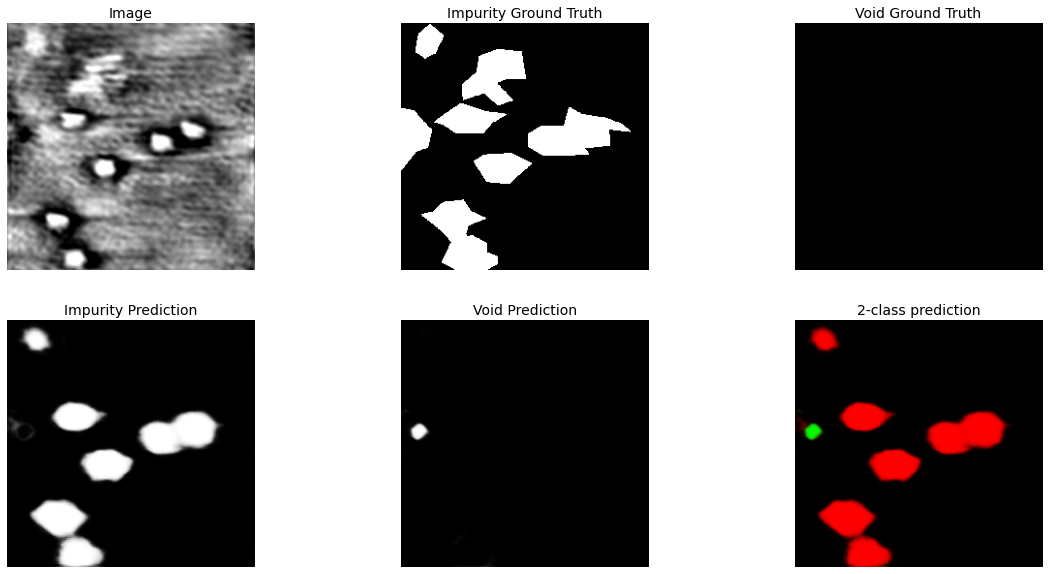

8/8 [==============================] - 22s 3s/step - loss: 0.2184 - accuracy: 0.9001 - val_loss: 0.3944 - val_accuracy: 0.9268
Epoch 199/200
8/8 [==============================] - ETA: 0s - loss: 0.2633 - accuracy: 0.9079

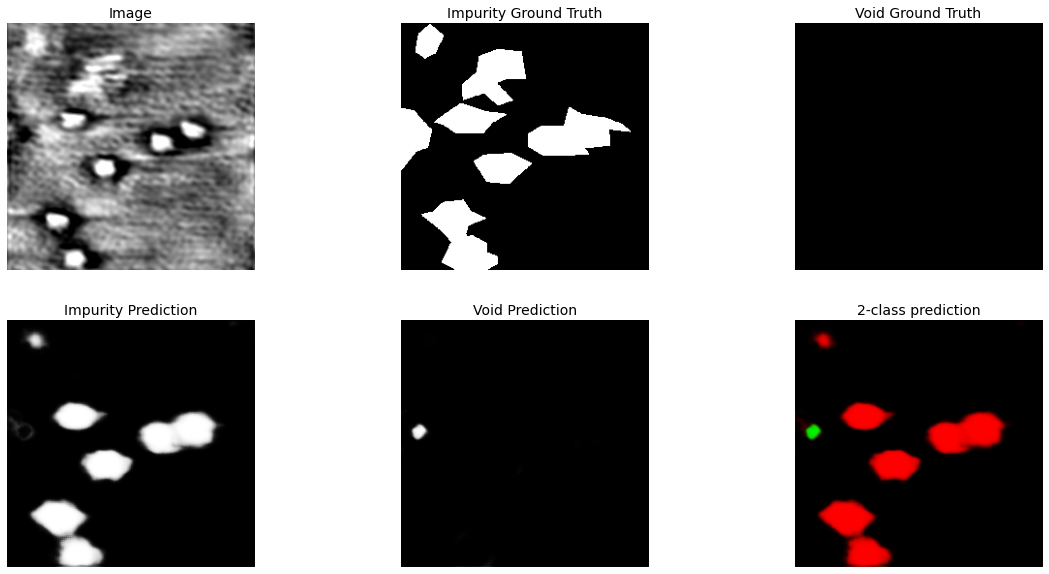

8/8 [==============================] - 22s 3s/step - loss: 0.2633 - accuracy: 0.9079 - val_loss: 0.3781 - val_accuracy: 0.9210
Epoch 200/200
8/8 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9024

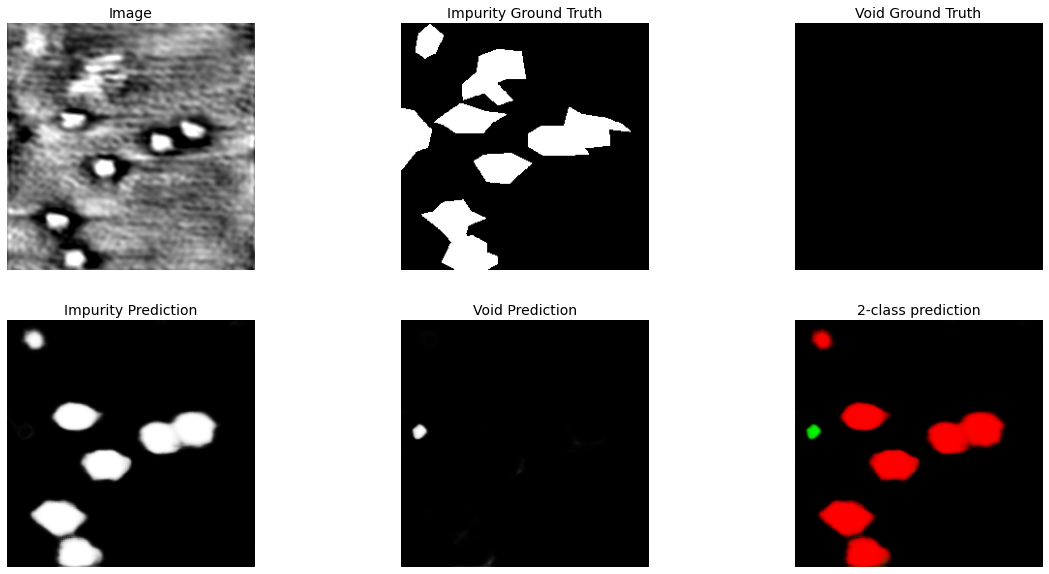

8/8 [==============================] - 22s 3s/step - loss: 0.2158 - accuracy: 0.9024 - val_loss: 0.4366 - val_accuracy: 0.9208


In [15]:
train_steps = dataset_train.num_images //batch_size
test_steps = dataset_val.num_images //batch_size

# code checking if ckpt exists
if int(os.path.isfile(model_path)):
    model_attached = load_model(model_path,custom_objects={"weighted_binary_crossentropy":create_weighted_binary_crossentropy(pos_weight)})
else:
    initial_epoch = 0
    model_attached = unet()

# print model summary 
model_attached.summary()

# history object
history = model_attached.fit(train_generator, 
          epochs = epochs,
          initial_epoch = initial_epoch,
          steps_per_epoch = 8,
          validation_data = test_generator,
          validation_steps = test_steps,
          callbacks = build_callbacks(),
          verbose = 1)


# Plot training and validation loss vs epoch 

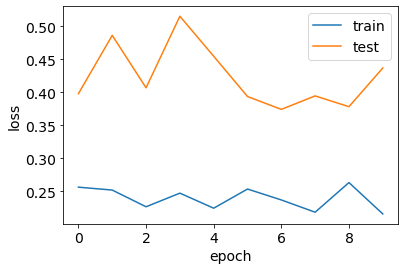

In [16]:
# set font size for all elements in plot
plt.rcParams.update({'font.size': 14})

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

f = open("loss.txt","w") #opens file with name of "test.txt"
f1 = open("val_loss.txt","w")
f.write(str(history.history['loss']).strip('[]'))
f1.write(str(history.history['val_loss']).strip('[]'))
f.close()
f1.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # This is added back by InteractiveShellApp.init_path()


Predict impurity number: 8 ground truth Impurity number: 9
Predict void number: 1 ground truth void number: 0


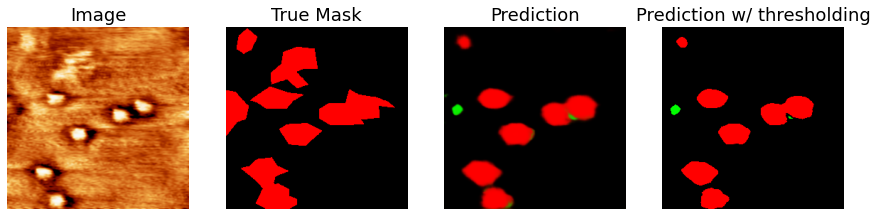

Predict impurity number: 9 ground truth Impurity number: 8
Predict void number: 9 ground truth void number: 10


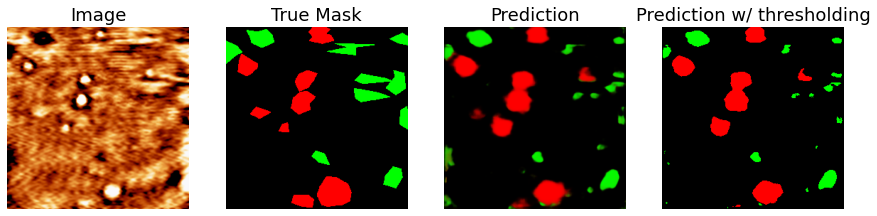

Predict impurity number: 16 ground truth Impurity number: 17
Predict void number: 1 ground truth void number: 0


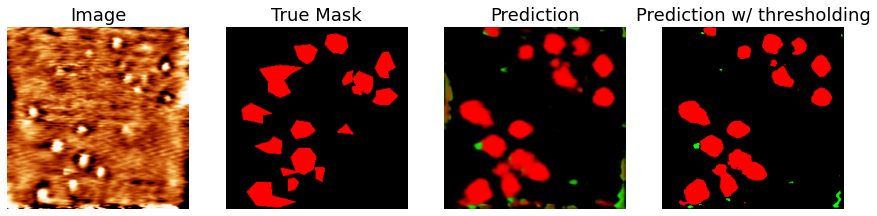

Predict impurity number: 24 ground truth Impurity number: 22
Predict void number: 1 ground truth void number: 3


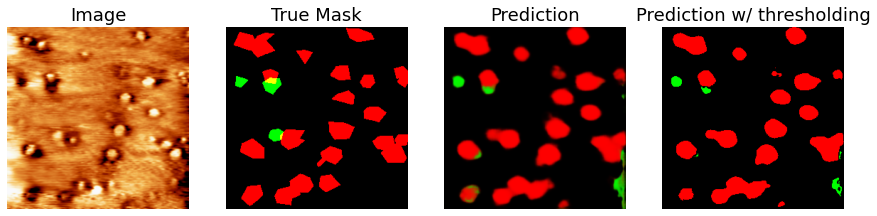

Predict impurity number: 5 ground truth Impurity number: 5
Predict void number: 1 ground truth void number: 1


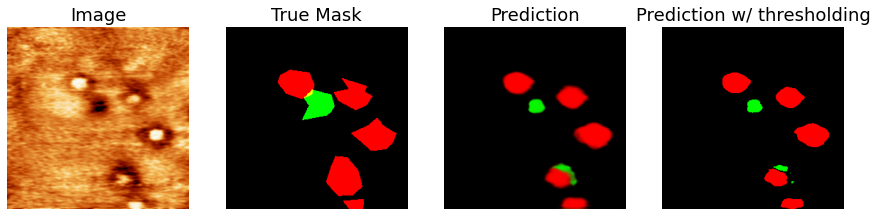

Predict impurity number: 24 ground truth Impurity number: 25
Predict void number: 3 ground truth void number: 2


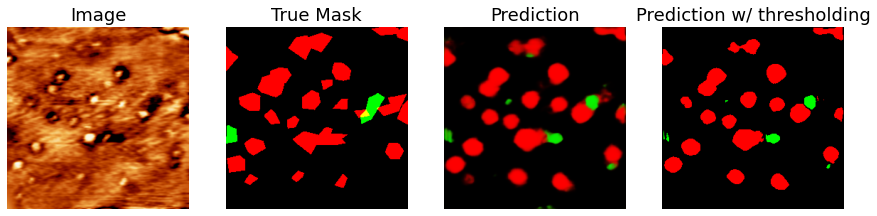

Predict impurity number: 10 ground truth Impurity number: 10
Predict void number: 2 ground truth void number: 2


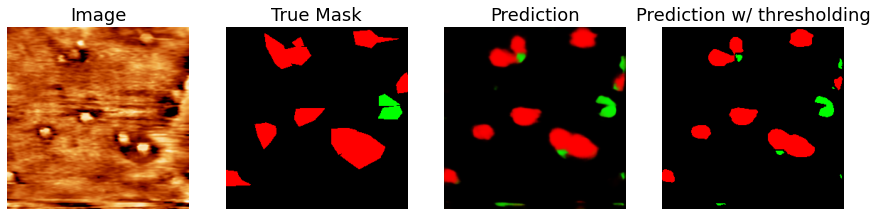

Predict impurity number: 21 ground truth Impurity number: 22
Predict void number: 4 ground truth void number: 3


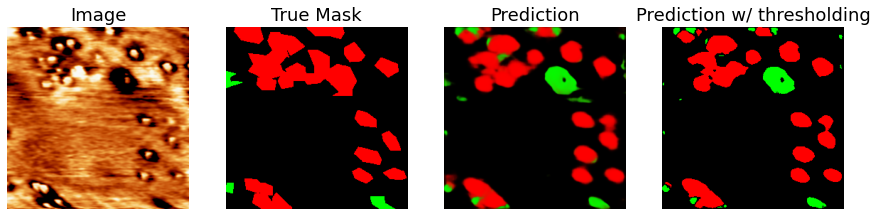

Predict impurity number: 5 ground truth Impurity number: 5
Predict void number: 1 ground truth void number: 1


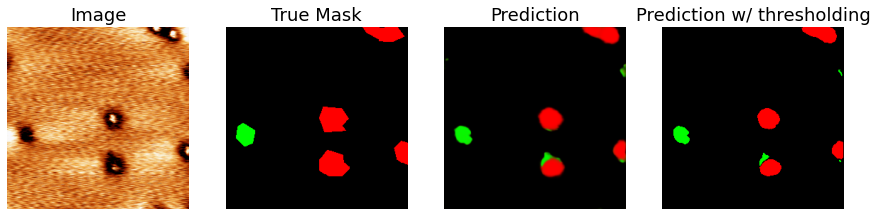

Predict impurity number: 4 ground truth Impurity number: 4
Predict void number: 4 ground truth void number: 4


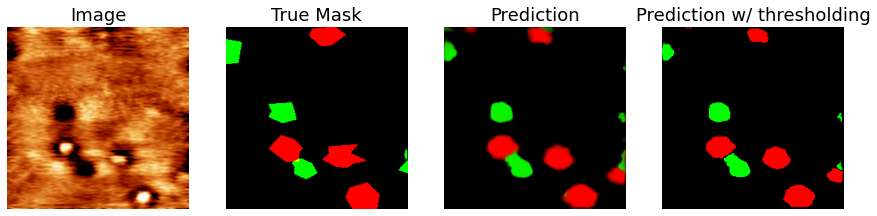

Predict impurity number: 16 ground truth Impurity number: 15
Predict void number: 8 ground truth void number: 9


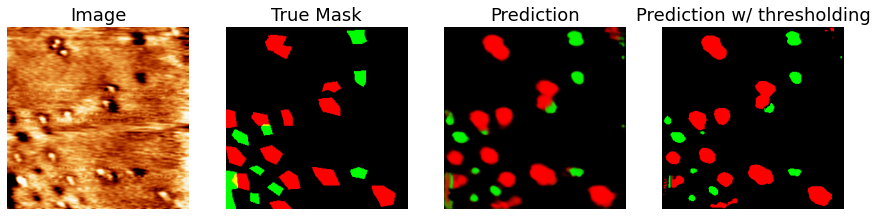

Predict impurity number: 18 ground truth Impurity number: 17
Predict void number: 2 ground truth void number: 3


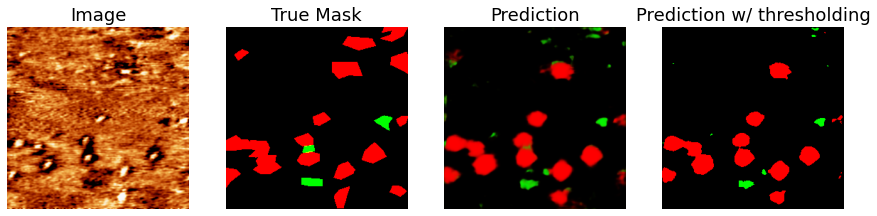

Predict impurity number: 14 ground truth Impurity number: 14
Predict void number: 0 ground truth void number: 0


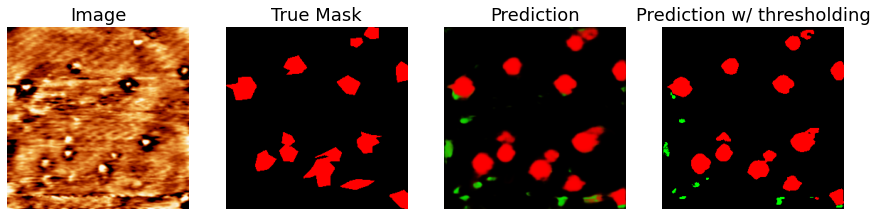

Predict impurity number: 7 ground truth Impurity number: 8
Predict void number: 2 ground truth void number: 1


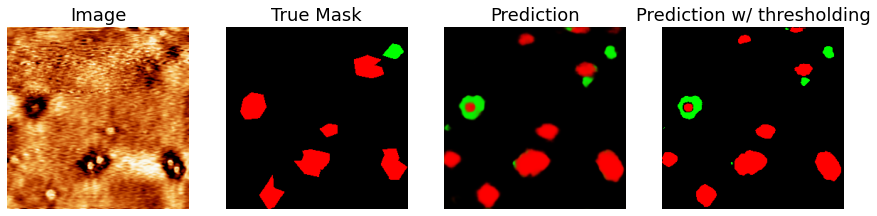

Predict impurity number: 7 ground truth Impurity number: 7
Predict void number: 4 ground truth void number: 4


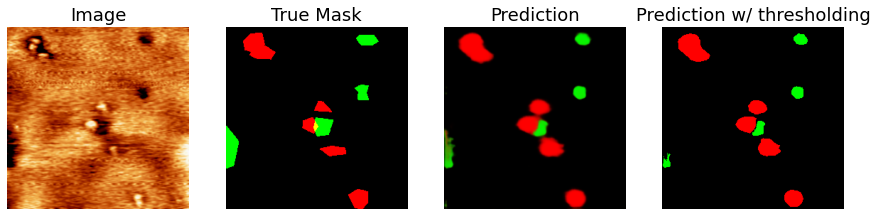

Predict impurity number: 16 ground truth Impurity number: 16
Predict void number: 6 ground truth void number: 6


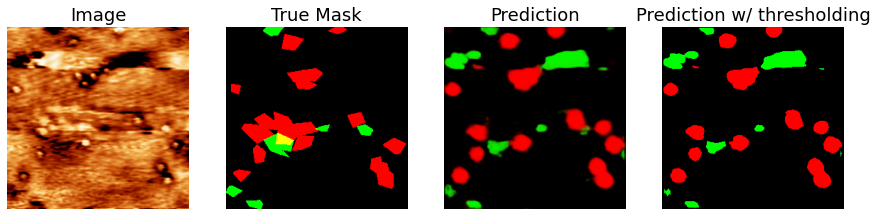

Predict impurity number: 18 ground truth Impurity number: 19
Predict void number: 10 ground truth void number: 9


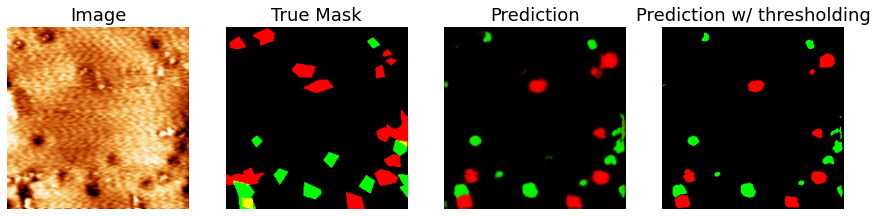

Predict impurity number: 19 ground truth Impurity number: 17
Predict void number: 8 ground truth void number: 10


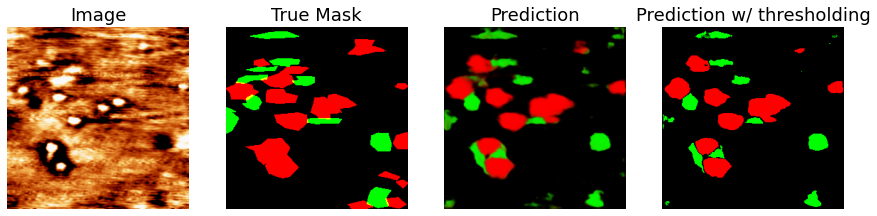

Predict impurity number: 7 ground truth Impurity number: 9
Predict void number: 3 ground truth void number: 1


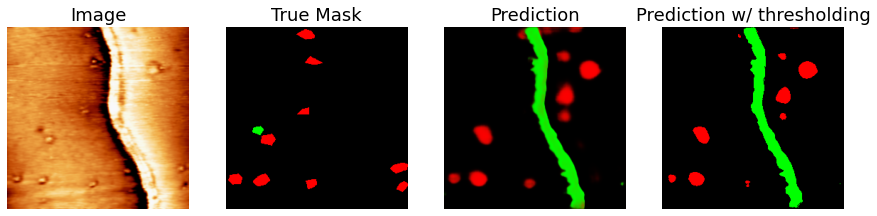

Predict impurity number: 26 ground truth Impurity number: 27
Predict void number: 8 ground truth void number: 7


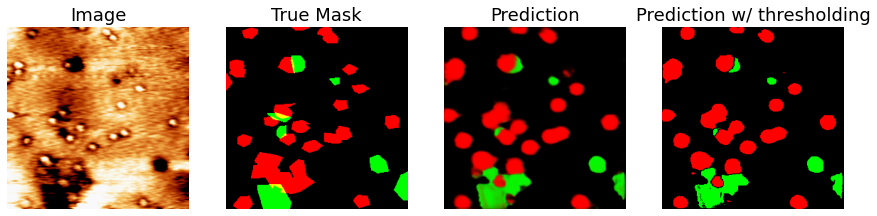

impurity recall: 0.94
void recall: 0.8

impurity Precision: 0.95
void Precision: 0.78

F1 impurity score: 0.94
F1 void score: 0.79

F2 impurity score: 0.94
F2 void score: 0.8


In [19]:
# Testing the number of the defects

#TP
impurity_number = 0
void_number = 0

#TP+FN
Real_impurity_number = 0 
Real_void_number = 0

#FP
FP_impurity_number = 0
FP_void_number = 0

for h in range(20):
  new_img =dataset_val.load_image(h)
  raw = cv2.resize(new_img,
        dsize=default_input_size[:2],
        interpolation=cv2.INTER_CUBIC)
  
  raw = rgb2gray(raw) 
 
  img=raw
  shape = img.shape[:]

  TFcircleIN   = draw_cicle(shape=img.shape[:],diamiter = 40)
  TFcircleOUT  = ~TFcircleIN

  fft_img = np.zeros_like(img,dtype=complex)

  fft_img[:,:] = np.fft.fftshift(np.fft.fft2(img[:,:]))

  fft_img_channel  = fft_img[:,:]
  temp1 = filter_circle(TFcircleIN,fft_img_channel)

  fft_img_filtered_IN = np.transpose(temp1)
  img_reco_filtered_IN  = inv_FFT_all_channel(fft_img_filtered_IN)

  raw = img_reco_filtered_IN
  raw = np.stack([raw,raw,raw], axis = -1)

  raw = np.array(tf.image.adjust_contrast(np.abs(raw), 1.3))
  pred = model_attached.predict(np.expand_dims(raw, 0)).squeeze()
  pred_mask = (pred >= 0.7).astype(np.float32) # pred >= threshold
  gt_mask = dataset_val.load_mask(h)
  image_impurity_number =0
  image_void_number = 0

  image_real_impurity_number = 0
  image_real_void_number = 0

  pre_void = 0
  pre_imp = 0
  for z in range(len(gt_mask[1])):
    mask_defect = np.clip(np.sum(gt_mask[0][:,:,[z]], axis = -1, keepdims = True), a_min = 0, a_max = 1)
    #mask_impurity = np.clip(np.sum(gt_mask[0][:,:,[i for i in range(len(gt_mask[1])) if gt_mask[1][i] ==1]], axis = -1, keepdims = True), a_min = 0, a_max = 1)
            
    mask_defect = cv2.resize(mask_defect.astype(np.float32), dsize=default_input_size[:2], interpolation=cv2.INTER_CUBIC)
    ##mask = np.clip(np.sum(gt_mask[0][:,:,[i for i in range(len(gt_mask[1])) if gt_mask[1][i] ==1]], axis = -1, keepdims = True), a_min = 0, a_max = 1)
    mask_defect[mask_defect != 0] = 1
    defect_count = pred_mask * mask_defect[:,:,None] 
    impurity_pixel = np.sum(defect_count[:,:,0])
    void_pixel = np.sum(defect_count[:,:,1])
    if impurity_pixel == np.max([impurity_pixel,void_pixel]):
      pre_imp+=1
      if gt_mask[1][z] ==1:
        impurity_number+=1
        image_impurity_number+=1
      else:
        FP_impurity_number+=1
    else:
      pre_void+=1
      if gt_mask[1][z] ==2:
        void_number+=1
        image_void_number+=1
      else:
        FP_void_number+=1
    if gt_mask[1][z] ==1:
      Real_impurity_number+=1
      image_real_impurity_number += 1
    if gt_mask[1][z] ==2:
      Real_void_number+=1
      image_real_void_number+=1
  val_mask = dataset_val.load_mask(h)
  mask_impurity = np.clip(np.sum(val_mask[0][:,:,[i for i in range(len(val_mask[1])) if val_mask[1][i] ==1]], axis = -1, keepdims = True), a_min = 0, a_max = 1)
  mask_void = np.clip(np.sum(val_mask[0][:,:,[i for i in range(len(val_mask[1])) if val_mask[1][i] ==2]], axis = -1, keepdims = True), a_min = 0, a_max = 1)

 # mask = cv2.resize(mask.astype(np.float32), dsize=default_input_size[:2], interpolation=cv2.INTER_CUBIC)
  mask_impurity = cv2.resize(mask_impurity.astype(np.float32), dsize=default_input_size[:2], interpolation=cv2.INTER_CUBIC)
  mask_void = cv2.resize(mask_void.astype(np.float32), dsize=default_input_size[:2], interpolation=cv2.INTER_CUBIC)
  
  mask_impurity[mask_impurity != 0 ] = 1
  mask_void[mask_void != 0 ] = 1

  print('Predict impurity number:',pre_imp,'ground truth Impurity number:',image_real_impurity_number)
  print('Predict void number:',pre_void,'ground truth void number:',image_real_void_number)
  h=np.zeros(np.shape(mask_impurity))
  mask = np.stack([mask_impurity,mask_void,h],axis=2)
  fig, ax = plt.subplots(1, 4, figsize=(15,60))
  [axi.set_axis_off() for axi in ax.ravel()]
  ax[0].imshow(new_img)
  ax[0].set_title('Image', fontsize=18)
  ax[1].imshow(mask)
  ax[1].set_title('True Mask',fontsize=18)
  ax[2].imshow(returnrgb(pred))
  ax[2].set_title('Prediction',fontsize=18)
  ax[3].imshow(returnrgb(pred_mask))
  ax[3].set_title('Prediction w/ thresholding',fontsize=18)
  plt.show()
    
      
def score(B,recall,precision):
  return ((1+B**2)*recall*precision)/(((B**2)*precision)+recall) 
impurity_recall=impurity_number/Real_impurity_number
void_recall=void_number/Real_void_number


impurity_precision=impurity_number/(impurity_number+FP_impurity_number)
void_precision=void_number/(void_number+FP_void_number)

 
F1_impurity=score(1,impurity_recall,impurity_precision)
F2_impurity=score(2,impurity_recall,impurity_precision)
F1_void=score(1,void_recall,void_precision)
F2_void=score(2,void_recall,void_precision)

print("impurity recall:",round(impurity_recall,2))
print("void recall:",round(void_recall,2))

print("\nimpurity Precision:",round(impurity_precision,2))
print("void Precision:",round(void_precision,2))

print("\nF1 impurity score:",round(F1_impurity,2))
print("F1 void score:",round(F1_void,2))

print("\nF2 impurity score:",round(F2_impurity,2))
print("F2 void score:",round(F2_void,2))

    

In [21]:
model_attached.save("/content/gdrive/MyDrive/defect_DL/Unet_h5_files/good_model.h5")